In [1]:
import datetime as dt
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from geopy import distance
from pandas.api.types import CategoricalDtype

主要研究问题是：

谁在使用共享自行车？会员与临时用户的行为是否存在明显差异？如果是，这些区别是什么？

人们何时使用共享自行车？一年、一周和一天的使用情况如何变化？

如何使用共享自行车？人们主要是使用自行车共享作为通勤上班或探索城市的方式吗？天气如何改变人们使用自行车的方式？

In [2]:
#%a 本地简化星期名称
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

# %B 本地完整的月份名称
months = [dt.datetime(2019, x, 1).strftime('%B') for x in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)

In [3]:
df = pd.read_csv('./data/bikeshare_ridership.csv')

# 把列名改一下
df.columns = [' '.join(x.replace('trip_', '').replace('_seconds', '').split('_')).title() for x in df.columns]

In [4]:
df['Start Time'] = pd.to_datetime(df['Start Time'])

df['Date'] = df['Start Time'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Quarter'] = df['Start Time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df['Month'] = df['Start Time'].apply(lambda x: x.strftime('%B')).astype(month_type)
df['Day of Week'] = df['Start Time'].apply(lambda x: x.strftime('%a')).astype(day_type)
df['Hour'] = df['Start Time'].apply(lambda x: x.strftime('%H'))

# 新增一列特征 "[start station ID]-[end station ID]" 
df['Route Id'] = df.apply(lambda x: '{0}-{1}'.format(int(x['Station Id From']), int(x['Station Id To'])), axis=1)

In [6]:
# 创建一个地图表
maps = df[['Route Id', 'Station Id From', 'Lat From', 'Lon From', 'Station Id To', 'Lat To', 'Lon To']].drop_duplicates()
maps['Distance'] = maps.apply(lambda x: distance.distance((x['Lat From'], x['Lon From']), (x['Lat To'], x['Lon To'])).km * 1000, axis=1)

In [7]:
# 合并两个表，在去除一些没有用的列
df = df.merge(maps[['Route Id', 'Distance']], how='left', on='Route Id')
df = df[[x for x in df.columns if not 'From' in x and not 'To' in x and x != 'Route Id']]

In [8]:
df.sample(10)

,Id,Start Time,Duration,User Type,Date,Quarter,Month,Day of Week,Hour,Distance
276917,1839260,2017-09-15 10:27:00,293,Member,2017-09-15,3,September,Fri,10,893.139950
535470,1994147,2017-10-03 22:46:18,243,Member,2017-10-03,4,October,Tue,22,602.320989
1322503,2193537,2017-11-04 00:09:26,260,Casual,2017-11-04,4,November,Sat,00,457.662800
356592,1683706,2017-08-26 16:03:00,1017,Casual,2017-08-26,3,August,Sat,16,1447.608892
781534,1422326,2017-07-24 08:26:00,1227,Member,2017-07-24,3,July,Mon,08,3303.358425
299125,1995566,2017-10-04 08:35:10,893,Member,2017-10-04,4,October,Wed,08,3824.508907
1129536,2029232,2017-10-08 22:24:52,626,Casual,2017-10-08,4,October,Sun,22,871.144937
862593,2207103,2017-11-07 13:10:49,413,Member,2017-11-07,4,November,Tue,13,1321.216747
176260,1287928,2017-07-05 18:58:00,907,Member,2017-07-05,3,July,Wed,18,3163.214668
418857,1016689,2017-05-17 16:47:00,184,Casual,2017-05-17,2,May,Wed,16,143.890496


谁在使用自行车共享？

我只能使用用户类型（成员与临时）,了解了用户类型，并可视化行程持续时间和距离的分布。

In [9]:
sns.set_style('dark')

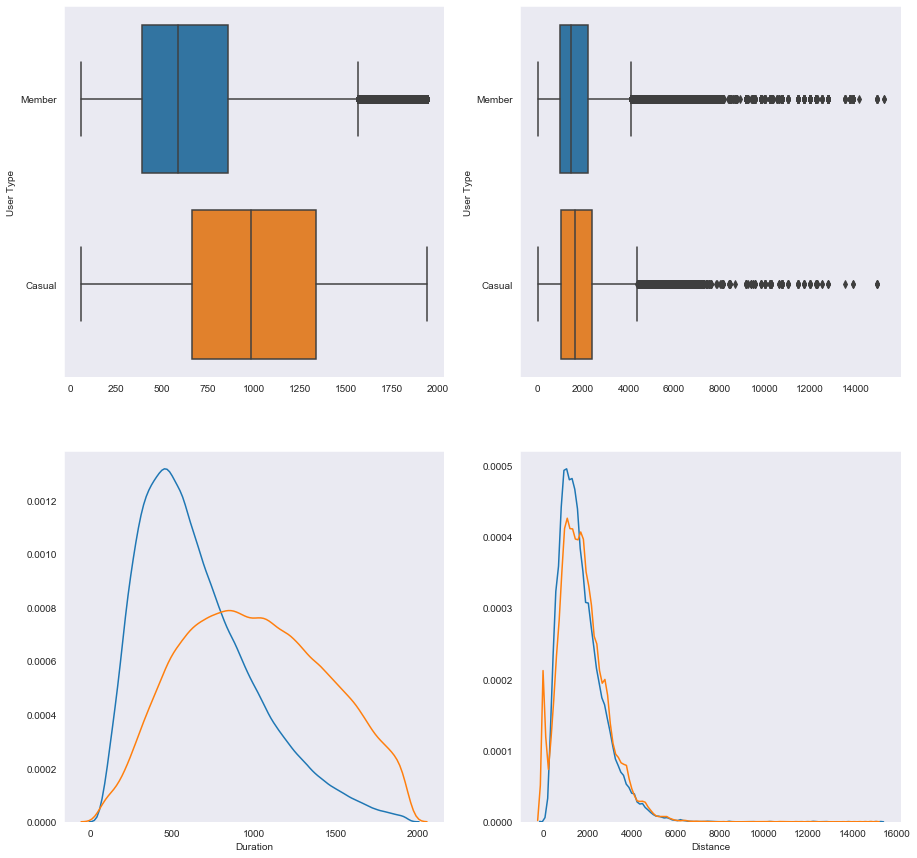

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))

for i, col in enumerate(['Duration', 'Distance']):
    #画分布图
    for j, user in enumerate(df['User Type'].unique()):
        sns.distplot(df[df['User Type']==user][col], hist=False, ax=ax2[i])
    
    # 箱线图
    sns.boxplot(x=col, y='User Type', data=df, ax=ax1[i])
    ax1[i].set_xlabel('')

plt.savefig('./visualization/distributions.png')

图中显示了会员和临时用户在行为上的明显差异：虽然两个组通常在相似的距离内旅行，但成员到达目的地的速度明显更快。
在接下来的部分中，我通过查看用户使用自行车的时间和方式，进一步细分了这些用户类型之间的行为差异。

什么时候使用自行车共享？

我按照用户类型和旅行日期汇总数据，并计算每天的旅行次数。

In [13]:
# 按日期字段和用户类型汇总乘客量，并计算唯一行程数
# nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量。用这个函数可以查看每个数据有多少个不同值。
ridership = df.groupby(['Date', 'Quarter', 'Month', 'Day of Week', 'User Type'])['Id'].nunique().reset_index().sort_values('User Type', ascending=False)

In [15]:
ridership.sample(10)

,Date,Quarter,Month,Day of Week,User Type,Id
110,2017-02-24,1,February,Fri,Casual,85
613,2017-11-02,4,November,Thu,Member,4065
296,2017-05-28,2,May,Sun,Casual,1666
46,2017-01-23,1,January,Mon,Casual,30
551,2017-10-02,4,October,Mon,Member,5895
637,2017-11-14,4,November,Tue,Member,4531
652,2017-11-22,4,November,Wed,Casual,136
258,2017-05-09,2,May,Tue,Casual,363
44,2017-01-22,1,January,Sun,Casual,105
340,2017-06-19,2,June,Mon,Casual,882


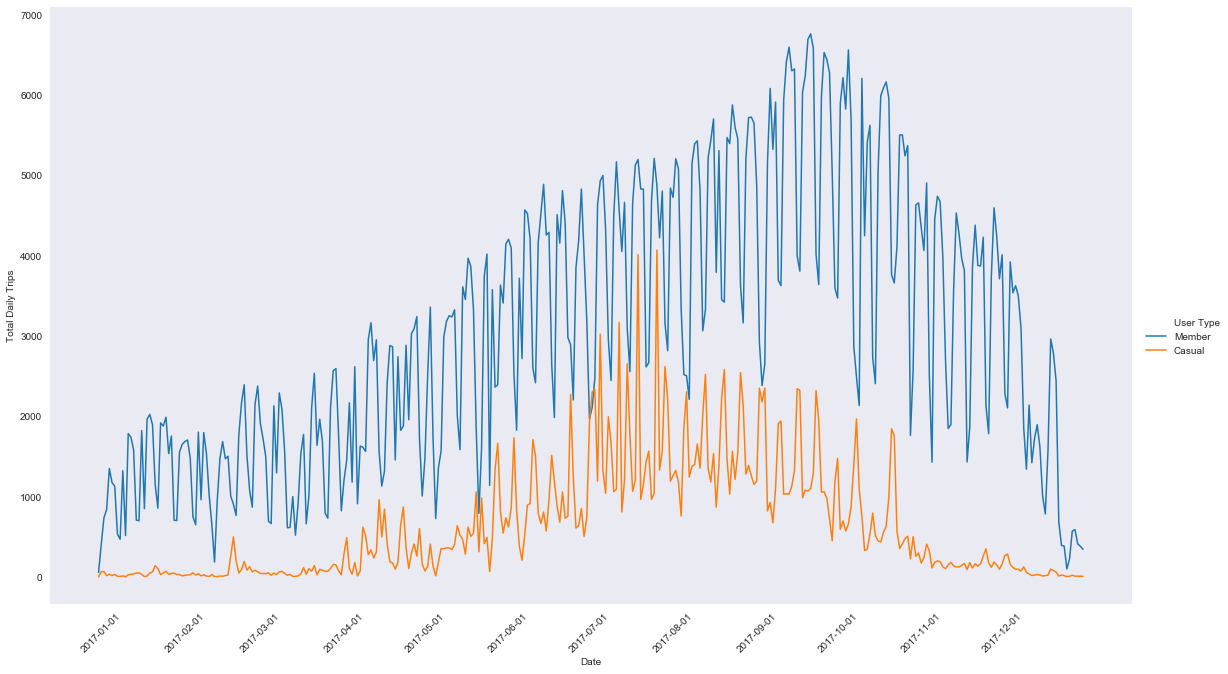

In [17]:
p = sns.relplot(x='Date', y='Id', hue='User Type', data=ridership, kind='line', height=9, aspect=16/9.)
p.ax.set_ylabel('Total Daily Trips')

# 将X轴上显示的标签数限制为仅显示每个月的第一天
p.ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in p.ax.get_xticklabels()], rotation=45)

plt.savefig('./visualization/ridership.png')

虽然图表显示了一些预期趋势（例如，在较暖的月份，乘客增加），但也出现了一些不太预期的模式：

旺季会员和临时用户之间的转变

小时间尺度上的持续上升和下降

我放大并可视化了几个月的数据，以便在更细粒度的层次上获得更好的视图。

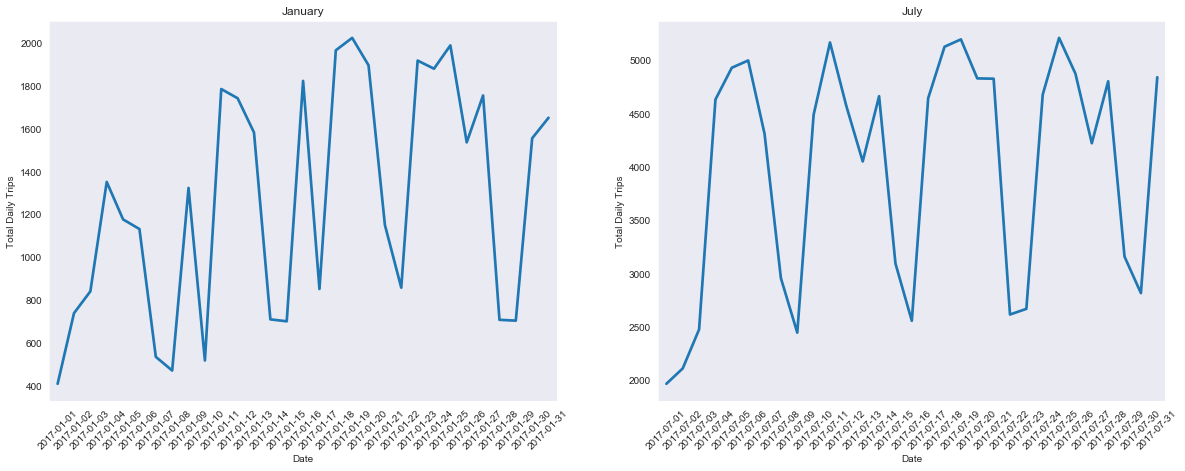

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for ax, m in zip(axes, ['January', 'July']):
    sns.pointplot(x='Date', y='Id', data=ridership[(ridership['Month']==m)&(ridership['User Type']=='Member')].groupby('Date')['Id'].sum().reset_index(), ax=ax, markers='')
    
    ax.set_title(m)
    ax.set_ylabel('Total Daily Trips')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig('./visualization/ridership_selection.png')

虽然7月份的趋势更为明显，但图表显示，乘客人数每周都在增加和减少。为了进一步梳理这个周期，我将每个工作日的平均每日行程可视化，并按季度和用户类型分离数据。

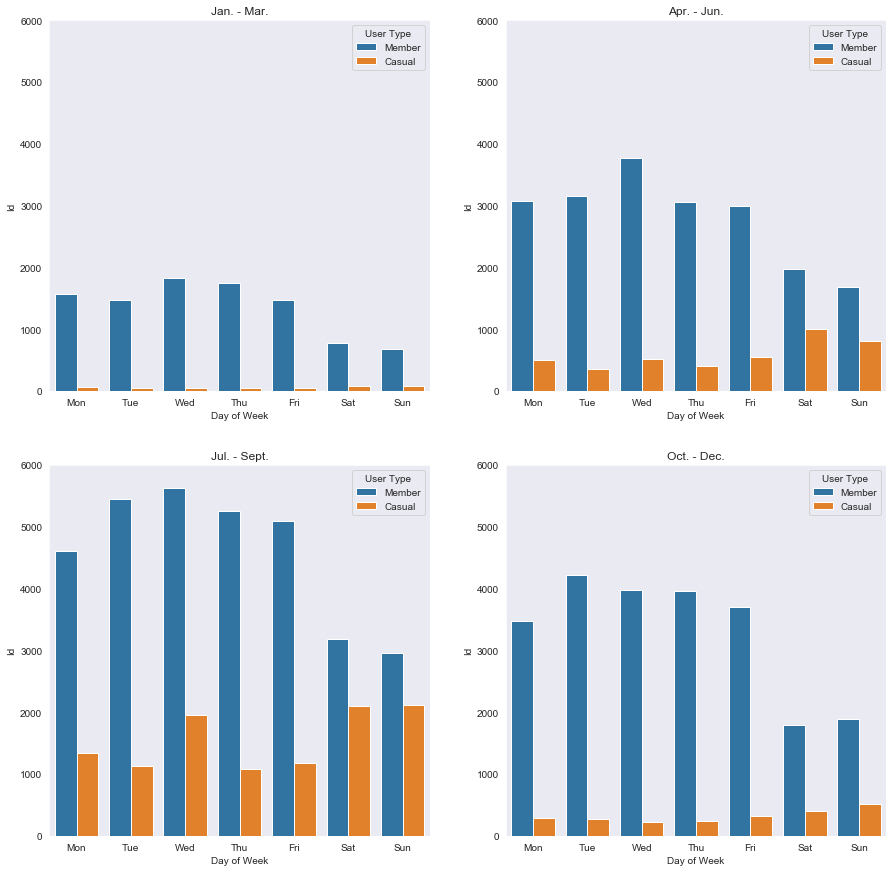

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = np.array(axes).flatten()                                               
quarter_names = ['Jan. - Mar.', 'Apr. - Jun.', 'Jul. - Sept.', 'Oct. - Dec.'] 

for q, ax in zip(sorted(ridership['Quarter'].unique()), axes):
    ax.set_title(quarter_names[(q-1)])
    
    ax.set_ylim(0, 6000)
    ax.set_ylabel('Average Daily Trips')
    
    viz = ridership[ridership['Quarter']==q].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index().sort_values('User Type', ascending=False)
    
    sns.barplot(
        x='Day of Week', 
        y='Id', 
        hue='User Type', 
        data=viz, 
        ax=ax
    )

plt.savefig('./visualization/quarterly.png')

这些图表进一步说明了不同的用户类型何时使用共享自行车：成员主要在工作日骑自行车，而休闲用户主要在周末骑自行车。唯一的例外是在第三季度，周三的休闲旅行显著增加。进一步深入研究了那些月份的数据，结果表明这实际上只发生在7月份。

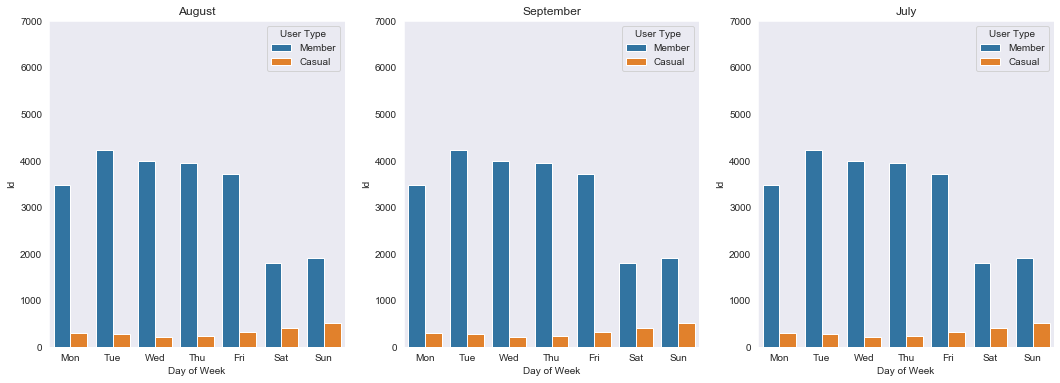

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = np.array(axes).flatten()

for m, ax in zip(ridership[ridership['Quarter']==3]['Month'].unique(), axes):
    ax.set_title(m)
    ax.set_ylim(0, 7000)
    ax.set_ylabel('Average Daily Trips')
    
    viz = ridership[ridership['Quarter']==q].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index().sort_values('User Type', ascending=False)

    
    sns.barplot(
        x='Day of Week', 
        y='Id', 
        hue='User Type', 
        data=viz, 
        ax=ax
    )
    
plt.savefig('./visualization/third_quarter.png')

谷歌的搜索显示，这是因为共享自行车在2017年7月周三提供了免费服务。

最后，我还想一小时一小时地看看一天中的乘客量趋势。

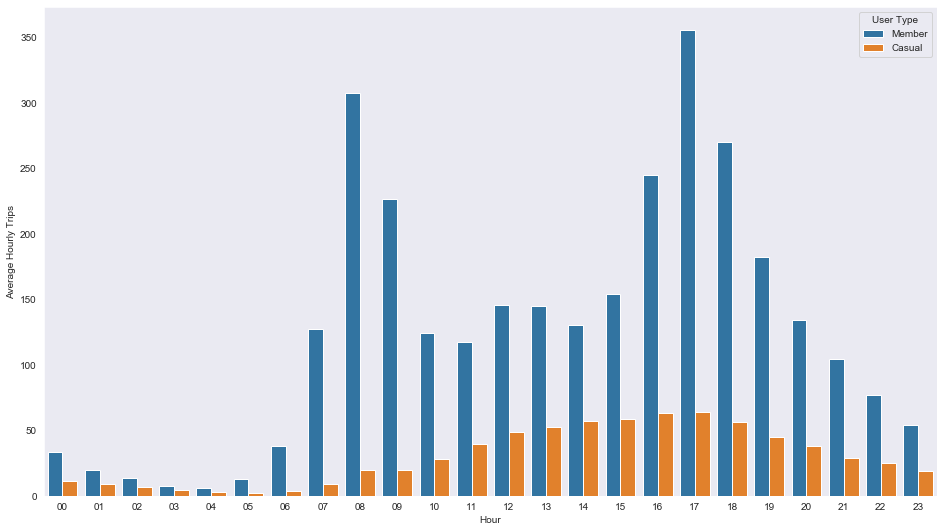

In [21]:
data = df.groupby(['Date', 'Hour', 'User Type'])['Id'].nunique().groupby(['Hour', 'User Type']).mean().reset_index().sort_values('User Type', ascending=False)

fig, ax = plt.subplots(figsize=(16, 9))

sns.barplot(x='Hour', y='Id', hue='User Type', data=data, ax=ax)
ax.set_ylabel('Average Hourly Trips')

plt.savefig('./visualization/hourly.png')

同样，此图显示了会员和临时用户在行为上的明显差异：会员在上午8点和下午5点左右经历高峰时间，而临时用户在一天中的一致性要高得多。

这与以前的研究结果相结合，即会员在工作日主要使用自行车共享，表明会员通常使用自行车共享作为通勤方式，而休闲用户则使用自行车共享进行休闲旅行。


如何使用自行车共享？
前几节中的分析已经回答了我关于如何使用自行车共享的几个问题（例如，会员通勤）。


相反，我决定在这一部分集中讨论天气和乘客量之间的关系。


我从加拿大政府的气象站获取了多伦多市气象站的每日温度和降水数据。

首先，我将乘客量数据与天气数据合并，并创建一个pairplot多变量图来了解变量之间的关系。此外，我还创建了一个热图来可视化变量之间的皮尔逊相关系数。

In [22]:
# 前22是说明，舍掉
weather = pd.read_csv('./data/weather.csv', header=22)
#去掉单位
weather.columns = [re.sub(r'\([^()]*\)', '', x).strip() if x != 'Date/Time' else 'Date' for x in weather.columns]

In [23]:
data = df.groupby(['Date', 'User Type'])['Id'].nunique().to_frame().pivot_table(index='Date', columns='User Type').reset_index()
data.columns = ['Date', 'Casual Trips', 'Member Trips']

data = data.merge(weather[['Date', 'Mean Temp', 'Total Precip']], on='Date', how='inner')

In [24]:
data.sample(10)

,Date,Casual Trips,Member Trips,Mean Temp,Total Precip
158,2017-06-08,896,4527,17.8,0.0
302,2017-10-30,257,4632,NaN,NaN
161,2017-06-11,1507,2418,23.9,0.0
250,2017-09-08,1103,5912,15.0,0.0
358,2017-12-25,6,100,-6.8,1.0
34,2017-02-04,52,751,-3.8,0.0
310,2017-11-07,200,4739,NaN,NaN
67,2017-03-09,70,2088,1.7,0.0
131,2017-05-12,407,3327,10.7,0.0
348,2017-12-15,26,1620,-6.4,0.5


C:\Users\56938\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\56938\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


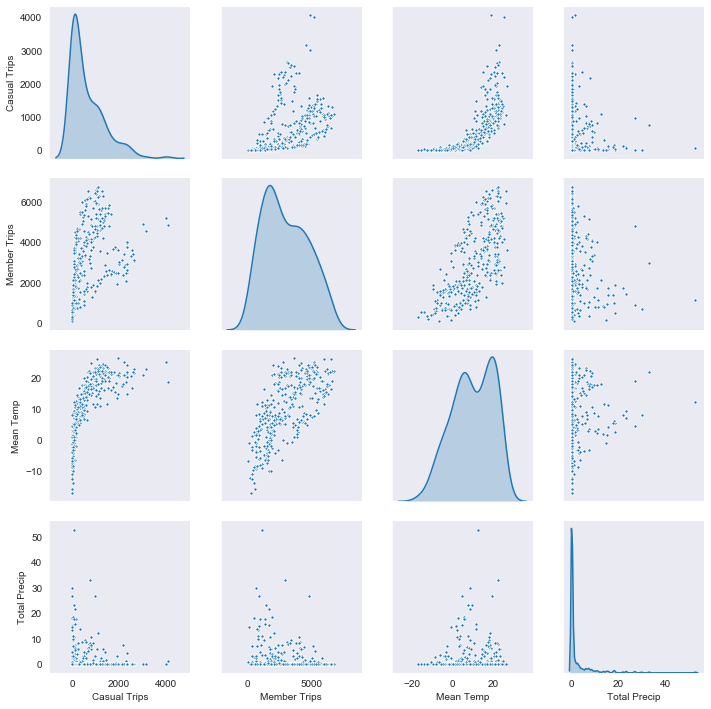

In [25]:
g = sns.pairplot(data, diag_kind='kde', plot_kws={'s': 10})
g.fig.set_size_inches(10, 10)

g.savefig('./visualization/pair.png')

因为降水量和乘客量之间的低相关性（可能因为是一天的降雨量可能是晚上下雨，或者下雨只在某一片区域），在接下来的分析中，将重点放在温度上。

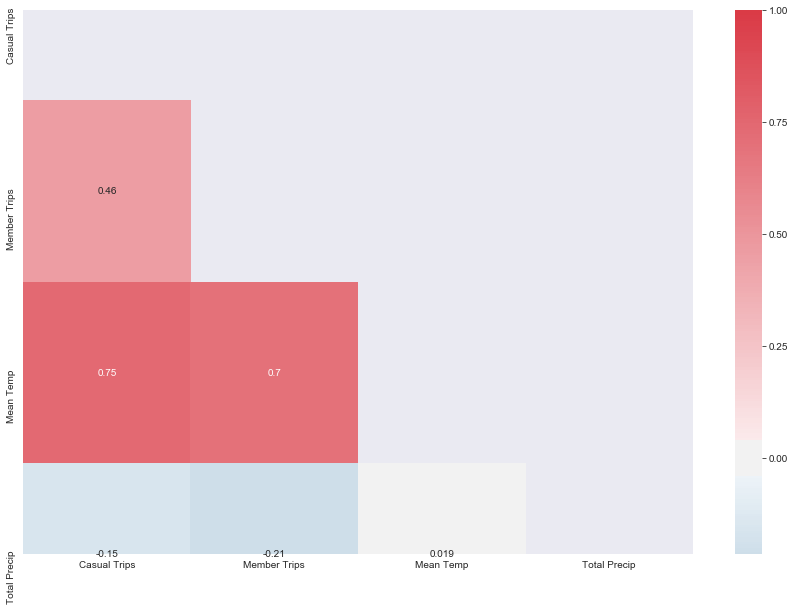

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))

corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap=True), center=0)

plt.savefig('./visualization/heatmap.png')

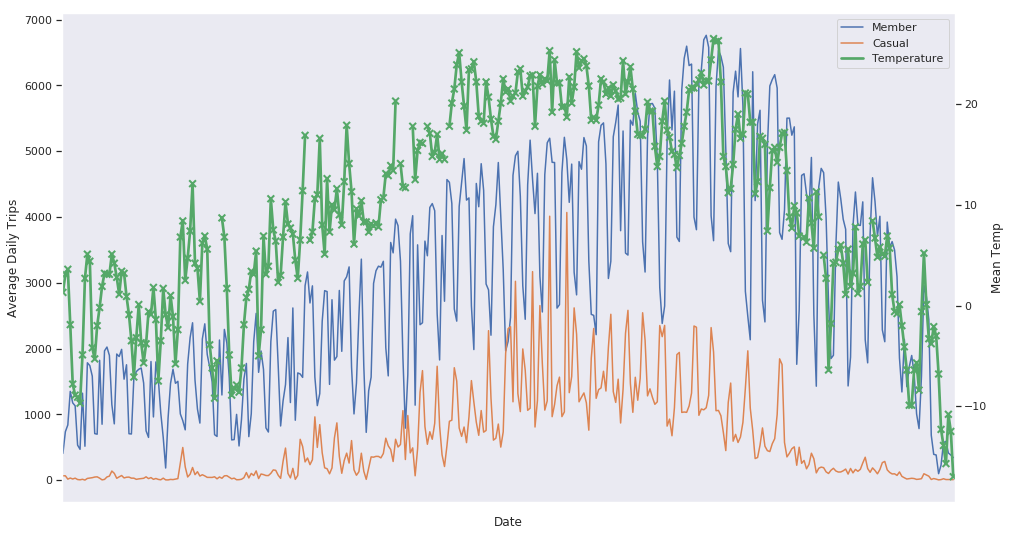

In [40]:
fig, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()              # 创建双轴，以便在同一图表上显示乘客人数和温度
palette = sns.color_palette() 

for i, user_type in enumerate(['Member Trips', 'Casual Trips']):
    sns.lineplot(x='Date', y=user_type, data=data, ax=ax, color=palette[i], markers='')
    
sns.pointplot(x='Date', y='Mean Temp', data=data, ax=ax2, color=palette[2], markers='x')

ax.set_ylabel('Average Daily Trips')
ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in ax.get_xticklabels()], rotation=45)

# Create the legend (due to the way this graph is created the default legend is not correct)
ax.legend(handles=ax.lines + ax2.lines, labels=['Member', 'Casual', 'Temperature'])
plt.savefig('./visualization/temperature.png')

事实上，人们在暖和的月份骑自行车的次数更多，所以我想更进一步，找出温度，这是人们决定是否骑自行车的转折点。我决定只关注临时用户，因为他们与温度的相关性更高，但同样的想法也适用于这两种用户类型。



最后，有一个kneed库，它提出了一种基于曲线图曲率的方法找到转折点。

In [28]:
data = data.sort_values('Mean Temp').dropna().reset_index(drop=True)

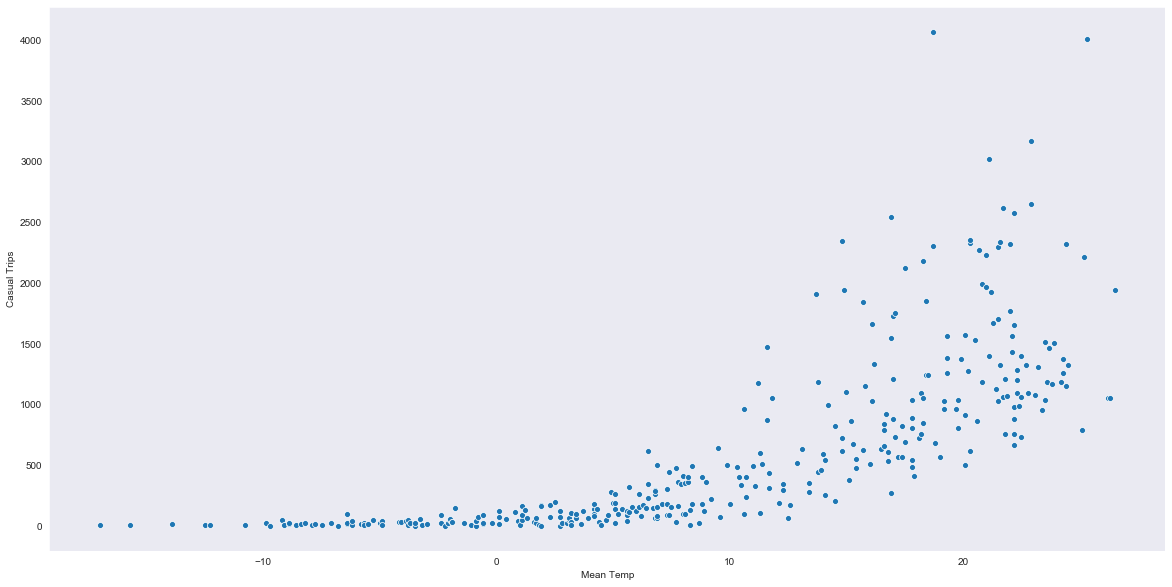

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x='Mean Temp', y='Casual Trips', data=data)
plt.savefig('./visualization/fit_0.png')

kneed库要求在确定点之前对数据进行曲线拟合。给出数据后，我将数据拟合为一个线性的函数，以及指数函数，然后评估结果。

In [47]:
from kneed import KneeLocator
from scipy.optimize import curve_fit

# Define the curve fitting equations
def linear(x, m, b):
    return m*x + b

def exp_growth_no_shift(x, a, b):
    return a * np.exp(-b * x)

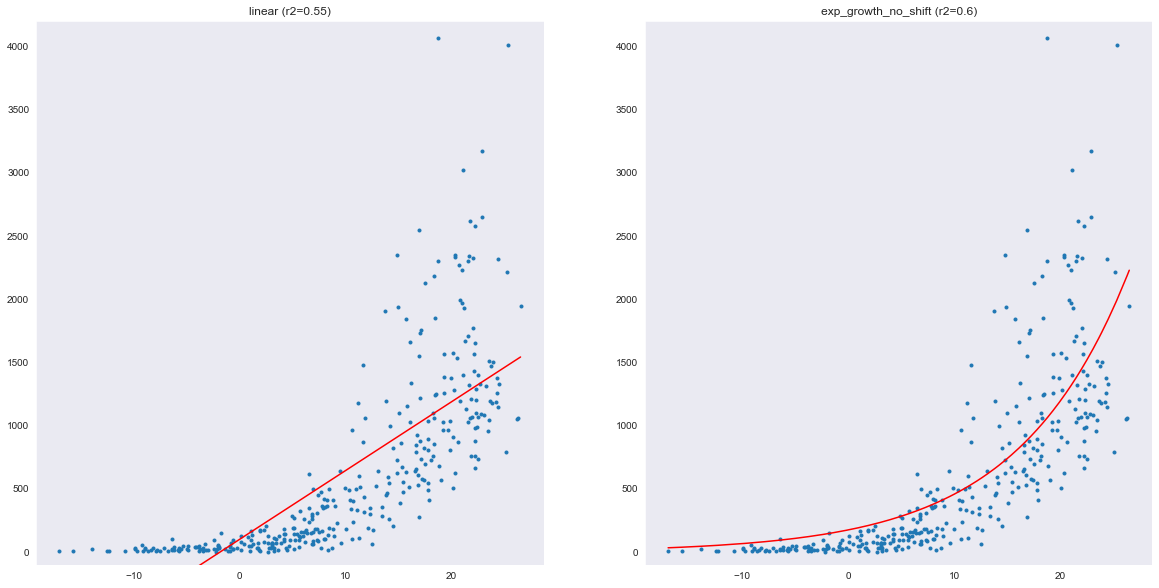

In [48]:
x = data['Mean Temp'].values
y = data['Casual Trips'].values


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for ax, func in zip(axes, [linear, exp_growth_no_shift]):
    popt, pcov = curve_fit(func, x, y, maxfev=2000)
    y_fit = func(x, *popt)
    
    r2 = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))

    ax.plot(x, y, '.')
    ax.plot(x, y_fit, 'r-')
    ax.set_ylim(-100, 4200)
    ax.set_title('{0} (r2={1})'.format(func.__name__, np.round(r2, 2)))

plt.savefig('./visualization/fig_1.png')

结果表明，该点温度为11.4℃。

In [49]:
popt, pcov = curve_fit(exp_growth_no_shift, x, y, maxfev=2000)

#
kneedle = KneeLocator(x=x, y=exp_growth_no_shift(x, *popt), curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

11.4
